# suffix tree

In [1]:
from graphviz import Source

In [2]:
# each bracketed slice mark represents a part of a text like array indexing
# [a/b] represents a part of text that starts at character of index a(inclusively) and ends at b(exclusively)

class SuffixNode: 
    counter = 1
    
    def __init__(self,text,start=0,end=0,depth=0,parent=None):
        # reference to the text(for accesing it with indexing)
        self.text = text
        
        # starting index of a text represented by the edge
        self.start = start
        # ending index
        self.end = end
        
        # self explainatory
        self.parent = parent        
        self.depth = depth
        self.children = {}
        
        # for finding a stubstring in text
        self.leaf_index = None
        
        # for visualisation
        self.id = SuffixNode.counter
        SuffixNode.counter += 1
    
    
    
    #adding a piece of a text to a node - creating a new edge in a tree
    def graft(self,new_start):

        # initially we set each ending of a grafted branch as the end of the text. It's always a suffix so we can do that
        new_end = len(self.text)
        
        # we calculate new depth of the child
        new_depth = self.depth + (new_end - new_start)
        
        # we create the new child
        child = SuffixNode(self.text,new_start,new_end,new_depth,self)
        self.children[self.text[new_start]] = child
        
        # note that the child is always a leaf node
        return child
    
    
    
    # break-path function breaks an edge of the tree and creates a new node at the breaking point
    def break_path(self,string):
        length = len(string)
        child = self.children[string[0]]
        
        # we create the new node(note that the information about an edge is stored in a child)
        new_node = SuffixNode(self.text,child.start,child.start+length,self.depth + length, self)
        child.start = child.start + length
        child.parent = new_node
        new_node.children[self.text[child.start]] = child
        self.children.pop(string[0])
        self.children[string[0]] = new_node
        
        # we have to return the node for further grafting operation
        return new_node
    
    
    
    # slow-find function's purpose is to find or create a new node that will start a new branch in a tree
    # it takes a string and follows it
    def slow_find(self,string):
        
        # it's a recursive function so it needs a stop condition
        # we stop if the string ends or if the node doesn't have the letter as it's key
        if len(string) == 0 or string[0] not in self.children.keys():
            return self
        
        # we get the next node from our path. We'll either travell through the whole length of the string...
        child = self.children[string[0]]
        for i in range(1, child.end-child.start):
            # ... or stop at the point where we find a mismatch
            if self.text[child.start+i] != string[i]:
                # in this case we'll have to break the path(create a new node between the processed parent and child)
                # it will be the returned node
                return self.break_path(string[:i])
        
        # if we manage to reach the end of slow-find's for loop we have to continue the recursion
        return child.slow_find(string[child.end-child.start:]) 
    
    
    
    # functions for visualisation
    def dot_node(self):
        return f'{self.id} [label="", shape="point"];'
    
    def dot_edges(self):
        result = []
        for child in self.children.values():
            if child.start+1 == child.end:
                newLabel = child.text[child.start]
            else:
                newLabel = f'[{child.start}/{child.end}]'
            result.append(f'{self.id} -> {child.id}[arrowhead="none", label=" {newLabel}"];')
        return "\n".join(result)
    
    def get_all_children(self):
        result = [self]
        for child in self.children.values():
            result += child.get_all_children()
        return result 
    
    def show_tree(self):
        nodes = self.get_all_children()
        SuffixNode.show_graph(nodes)
    
    @staticmethod
    def show_graph(nodes):
        result = "digraph{\n"
        ranks = {}
        for node in nodes:
            result += node.dot_node() + "\n"
            result += node.dot_edges() + "\n"
            if(node.depth not in ranks):
                ranks[node.depth] = []
            ranks[node.depth].append(node.id)
        for key, values in ranks.items():
            values = " ".join([f"{v};" for v in values])
            result += " { rank=same; " + values + "}\n"
        result += "\n}"
        s = Source(result)
        display(s)


In [3]:
class SuffixTree:
    def __init__(self,text):
        
        # we initialize the root node
        self.root = SuffixNode(text)
        leaf = self.root.graft(0)
        leaf.leaf_index = 0
        
        # and for each suffix in the text
        for i in range(1, len(text)):
            
            # we find and/or break the edge at which the path defined by the suffix ends in the existing tree
            head = self.root.slow_find(text[i:])
            
            # then we add a new node there and continue the process
            leaf = head.graft(i+head.depth)
            
            # and we index the leaf to allow us to look up strgins easily
            leaf.leaf_index = i
    
    
    
    # this function, for certain pattern, returns indexes at which that pattern starts
    def find_string(self,pattern): 
        result = []
        
        # the depth-first search recursive function that finds every leaf in a subtree and adds it to the resulting set
        def dfs(node):
            if len(node.children) == 0:
                result.append(node.leaf_index)
            else:
                for child in node.children.values():
                    dfs(child)
        
        # we'll descend down the tree following the letters in the pattern
        node = self.root
        # i will define our letters
        i = 0
        
        while True:    
            # of course we can only descent from the node if it has a child matching the lettern from our string
            if pattern[i] in node.children.keys():
                child = node.children[pattern[i]]
                
                # we'll have to move the considered node to the position of it's child
                # this will happen only if the remaining length of our string is greater than the one represented by the edge
                if len(pattern[i:]) > child.end-child.start:
                    # to go further, those parts must be identical
                    if pattern[i:i+child.end-child.start] == child.text[child.start:child.end]:
                        node = child
                        i = child.end
                    # otherwise it will mean that there are no such patterns appearing in the text 
                    else: return result 
                        
                # if our remaining length of the pattern is smaller than the edge's, 
                # we have to compare the piece of the same length
                elif pattern[i:] == child.text[child.start:child.start+len(pattern)-i]:
                    dfs(child)
                    return result
                else: return result
            else: return result
                  
        
    
    # visualisation
    def show_stree(self):
        self.root.show_tree()

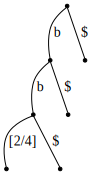

In [4]:
text0 = "bbb$"
tree0 = SuffixTree(text0)
tree0.show_stree()

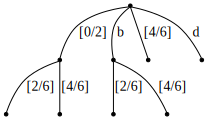

In [5]:
text1 = "ababcd"
tree1 = SuffixTree(text1)
tree1.show_stree()

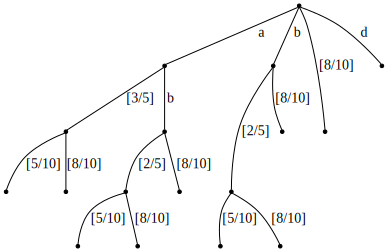

In [6]:
text2 = "abaabaabcd"
tree2 = SuffixTree(text2)
tree2.show_stree()

In [7]:
tree2.find_string("abaab")

[0, 3]